# **Import libraries**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.image as mpimg
import pandas as pd
import wandb
import random
import numpy as np
from wandb.keras import WandbCallback
import glob as gb
import cv2
import keras
import pathlib

# **Load dataset**

In [7]:
code = {'Cat':0 ,'Dog':1 }

In [8]:
data_dir = pathlib.Path('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages')

In [9]:
pet_images_dict = {
    'cats': list(data_dir.glob('Cat/*')),
    'dogs': list(data_dir.glob('Dog/*')),
}

pet_labels_dict = {
    'cats': 0,
    'dogs': 1,
}

In [10]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
X, Y = [], []

for pet_name, images in pet_images_dict.items():
    print(pet_name)
    for image in images:
        img = cv2.imread(str(image))
        if isinstance(img,type(None)): 
            #print('image not found')
            continue
            
        elif ((img.shape[0] >= IMAGE_HEIGHT) and  (img.shape[1] >=IMAGE_WIDTH)):
            resized_img = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
            X.append(resized_img)
            Y.append(pet_labels_dict[pet_name])
        else:
            #print("Invalid Image")
            continue

print(f'we have {len(X)} items in X ')

cats


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


dogs


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


we have 22039 items in X 


In [11]:
Y = np.array(Y).reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder()
y=Y=one.fit_transform(Y).toarray()
X = np.array(X)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,  shuffle=True, random_state=42)

# **Build model**

In [15]:
# https://keras.io/api/applications/
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224, 224, 3), weights = 'imagenet',include_top=False)
base_model.trainable = False

In [16]:
inputs = base_model.input

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

#model.summary()

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
X_train.shape

(8815, 224, 224, 3)

In [19]:
y_train.shape

(8815, 2)

In [20]:
history = model.fit(X_train, y_train, batch_size=32,epochs=5)

Epoch 1/5


2023-03-30 22:52:42.271044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


276/276 [==============================] - 29s 55ms/step - loss: 0.3330 - accuracy: 0.9789
Epoch 2/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0705 - accuracy: 0.9925
Epoch 3/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0120 - accuracy: 0.9960
Epoch 4/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0139 - accuracy: 0.9967
Epoch 5/5
276/276 [==============================] - 15s 55ms/step - loss: 0.0133 - accuracy: 0.9971


In [21]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
69/69 [==============================] - 6s 58ms/step - loss: 0.0548 - accuracy: 0.9905
test loss, test acc: [0.054837048053741455, 0.9904718399047852]


# **Evaluation**

In [22]:
y_pred = model.predict(X_test)

69/69 [==============================] - 6s 51ms/step


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1) ) )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1085
           1       0.99      0.99      0.99      1119

    accuracy                           0.99      2204
   macro avg       0.99      0.99      0.99      2204
weighted avg       0.99      0.99      0.99      2204



# **GRAD_CAM**

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

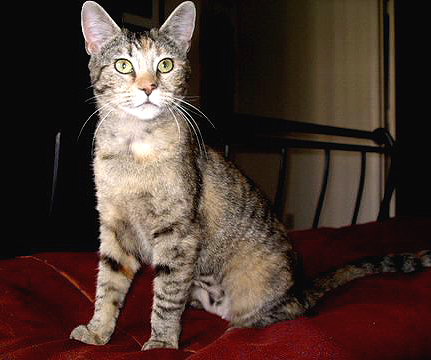

In [66]:
img_size = (224, 224)
preprocess_input = keras.applications.efficientnet.preprocess_input
last_conv_layer_name = "top_conv"
img_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/10000.jpg"

display(Image(img_path))

In [67]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 33ms/step


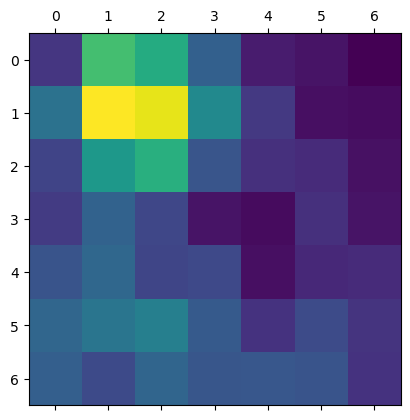

In [68]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

pred_index=0

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)

# Display heatmap
plt.matshow(heatmap)
plt.show()

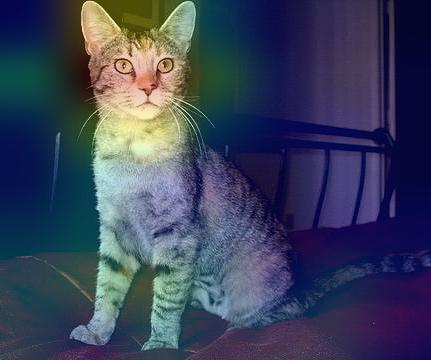

In [69]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)